In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd

import re

## Features 

In [2]:
import re

indexes = []
features = []
with open('../homework2_exercise2/data/features', 'r') as f:
    for line in f.readlines():
        index, *feat = line.split(':')
        feat = ''.join(feat)
        feat = re.findall('"([^\"]*)"', feat)
        indexes.append(index)
    
        
        feat += [f.split('_')[0] for f in feat]
        feat = list(set(feat))
        
        features.append(feat)

In [3]:
one_hot = MultiLabelBinarizer()
mhe = one_hot.fit_transform(features)
df = pd.DataFrame(mhe)

In [4]:
df.rename(columns=lambda x: f'feat_{x}', inplace=True)
df = df.T.drop_duplicates().T
df = df.astype(bool)
df['theorem'] = indexes

In [5]:
del mhe
del features
del indexes

# Dataset

## Ones

In [6]:
indexes_train = []
premises = []

ones = []

with open('../homework2_exercise2/data/dependencies_train', 'r') as f:
    for line in f.readlines():
        index, *prem = line.split(':')
        prem = ''.join(prem).split()
        
        indexes_train.append(index)
        premises.append(prem)
        
        for p in prem:
            ones.append((index, p))

In [7]:
ones_df = pd.DataFrame(ones, columns=['theorem', 'premise']).drop_duplicates()

In [8]:
del ones
del premises
del indexes_train

## Zeros

In [9]:
chronology = pd.read_csv('../homework2_exercise2/data/chronology_backup', squeeze=True, names=['chronology'])
def get_available_theorems(name):
    return chronology.loc[:(chronology == name).argmax()-1]

In [10]:
used_premises = ones_df.groupby('theorem')['premise'].unique()

In [11]:
FALSE_EXAMPLES_RATIO = 2

dataset_zeros = []
for theorem, theorem_premises in ones_df.groupby('theorem')['premise']:
    available_theorems = get_available_theorems(theorem)
    zero_premises = np.setdiff1d(available_theorems, theorem_premises)
    
    zeros_chosen = zero_premises[np.random.randint(0, len(zero_premises), FALSE_EXAMPLES_RATIO * theorem_premises.shape[0])]
    dataset_zeros += list(zip(
        [theorem] * len(zeros_chosen),
        zeros_chosen
    ))

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
zeros_df = pd.DataFrame(dataset_zeros, columns=['theorem', 'premise'])

In [13]:
del dataset_zeros
del used_premises

### autoencoder

In [14]:
df.shape

(4564, 4872)

In [15]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 64

# this is our input placeholder
input_data = Input(shape=(4871,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(4871, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [16]:
encoder = Model(input_data, encoded)

In [17]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [18]:
autoencoder.fit(df.drop('theorem', axis=1), df.drop('theorem', axis=1),
                epochs=400,
                batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/400
4564/4564 [==============================] - 2s 431us/step - loss: 0.6921
Epoch 2/400
4564/4564 [==============================] - 1s 112us/step - loss: 0.6899
Epoch 3/400
4564/4564 [==============================] - 1s 116us/step - loss: 0.6872
Epoch 4/400
4564/4564 [==============================] - 1s 125us/step - loss: 0.6828
Epoch 5/400
4564/4564 [==============================] - 1s 115us/step - loss: 0.6736
Epoch 6/400
4564/4564 [==============================] - 1s 113us/step - loss: 0.6516
Epoch 7/400
4564/4564 [==============================] - 1s 112us/step - loss: 0.6004
Epoch 8/400
4564/4564 [==============================] - 1s 118us/step - loss: 0.5043
Epoch 9/400
4564/4564 [==============================] - 1s 112us/step - loss: 0.3801
Epoch 10/400
4564/4564 [==============================] - 1s 114us/step - loss: 0.2727
Epoch 11/400
4564/4564 [==============================] - 1s 110us/step - loss: 0.2000
Epoc

4564/4564 [==============================] - 1s 117us/step - loss: 0.0210
Epoch 186/400
4564/4564 [==============================] - 1s 113us/step - loss: 0.0209
Epoch 187/400
4564/4564 [==============================] - 1s 119us/step - loss: 0.0209
Epoch 188/400
4564/4564 [==============================] - 1s 113us/step - loss: 0.0209
Epoch 189/400
4564/4564 [==============================] - 1s 119us/step - loss: 0.0208
Epoch 190/400
4564/4564 [==============================] - 1s 116us/step - loss: 0.0208
Epoch 191/400
4564/4564 [==============================] - 1s 115us/step - loss: 0.0208
Epoch 192/400
4564/4564 [==============================] - 1s 114us/step - loss: 0.0208
Epoch 193/400
4564/4564 [==============================] - 1s 114us/step - loss: 0.0207
Epoch 194/400
4564/4564 [==============================] - 1s 117us/step - loss: 0.0207
Epoch 195/400
4564/4564 [==============================] - 1s 117us/step - loss: 0.0207
Epoch 196/400
4564/4564 [=====================

4564/4564 [==============================] - 1s 111us/step - loss: 0.0172
Epoch 372/400
4564/4564 [==============================] - 1s 115us/step - loss: 0.0172
Epoch 373/400
4564/4564 [==============================] - 0s 109us/step - loss: 0.0172
Epoch 374/400
4564/4564 [==============================] - 1s 112us/step - loss: 0.0172
Epoch 375/400
4564/4564 [==============================] - 1s 112us/step - loss: 0.0171
Epoch 376/400
4564/4564 [==============================] - 1s 110us/step - loss: 0.0171
Epoch 377/400
4564/4564 [==============================] - 1s 111us/step - loss: 0.0171
Epoch 378/400
4564/4564 [==============================] - 1s 110us/step - loss: 0.0171
Epoch 379/400
4564/4564 [==============================] - 1s 111us/step - loss: 0.0171
Epoch 380/400
4564/4564 [==============================] - 1s 111us/step - loss: 0.0171
Epoch 381/400
4564/4564 [==============================] - 1s 117us/step - loss: 0.0171
Epoch 382/400
4564/4564 [=====================

In [19]:
df_autoenc = pd.DataFrame(encoder.predict(df.drop('theorem', axis=1)))

In [20]:
df_autoenc['theorem'] = df['theorem']

In [21]:
df_autoenc.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,theorem
0,0.174485,5.802565,6.572248,1.046988,3.771890,1.628584,3.254599,0.632132,1.195083,0.000000,...,0.316736,0.000000,4.056600,0.000000,3.393760,2.833054,1.295640,1.076325,0.551563,abstractness_v1_orders_2
1,0.294873,5.713292,6.668814,1.089301,3.972167,1.774259,2.961862,0.285862,0.906719,0.000000,...,0.375667,0.000000,4.005151,0.054627,3.275133,3.227659,1.427314,0.848495,0.510101,abstractness_v1_pre_topc
2,0.131523,4.889763,5.338396,1.082238,3.030603,1.452361,2.509691,0.406721,0.823919,0.151467,...,0.156697,0.003650,2.910199,0.000000,2.635356,2.395504,1.230138,0.914943,0.586513,abstractness_v3_lattices
3,0.080363,5.033637,5.618406,1.035449,3.385143,1.445679,2.727648,0.422816,0.960209,0.000000,...,0.217018,0.031132,3.358080,0.072804,2.842786,2.562266,1.053204,0.815004,0.459143,abstractness_v6_waybel_0
4,0.000110,4.631509,4.395852,1.430120,2.238285,1.521761,2.045663,0.236124,0.994178,0.000000,...,0.131784,0.000000,2.043671,0.009435,1.827108,2.604370,1.144447,1.004012,0.368320,antisymmetry_r2_hidden


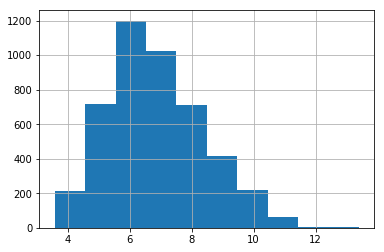

In [23]:
df_autoenc[1].hist()

##  Merging

In [14]:
zeros_df['useful'] = 0
ones_df['useful'] = 1
df_merged = pd.concat([zeros_df, ones_df])

In [15]:
del zeros_df
del ones_df

In [17]:
df_feats = df

In [16]:
df_feats = pd.concat([df, df_autoenc.drop('theorem', axis=1)], axis=1)

NameError: name 'df_autoenc' is not defined

In [18]:
def map_features(thm_prem_pairs):
    df_values = pd.merge(
        thm_prem_pairs, df_feats,
        left_on=['theorem'],
        right_on=['theorem']
    )
    df_values = pd.merge(
        df_values, df_feats,
        left_on=['premise'],
        right_on=['theorem'],
        suffixes=('_prem', '_thm')
    ).drop(['theorem_thm'], axis=1).rename(columns={'theorem_prem': 'theorem'})
    return df_values

In [19]:
df_train = map_features(df_merged)
df_train.head()

,theorem,premise,useful,feat_0_prem,feat_1_prem,feat_2_prem,feat_3_prem,feat_4_prem,feat_6_prem,feat_7_prem,...,feat_10348_thm,feat_10353_thm,feat_10355_thm,feat_10358_thm,feat_10361_thm,feat_10362_thm,feat_10365_thm,feat_10368_thm,feat_10373_thm,feat_10376_thm
0,t100_tmap_1,t41_waybel_0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,t27_waybel_7,t41_waybel_0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,t100_tmap_1,rc3_compts_1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,t120_tmap_1,rc3_compts_1,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,t122_tmap_1,rc3_compts_1,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
df_train.shape

(82299, 9745)

In [21]:
from sklearn.datasets import dump_svmlight_file
dump_svmlight_file(df_train.drop(['theorem', 'premise', 'useful'], axis=1), df_train['useful'], 'train.libsvm')

# Training 

In [23]:
import lightgbm as lgb

In [32]:
# train test split
from sklearn.model_selection import train_test_split
train_theorems, test_theorems = train_test_split(df_train['theorem'].unique(), shuffle=True, train_size=0.60)

train = df_train['theorem'].isin(train_theorems)
test = df_train['theorem'].isin(test_theorems)

features = list(df_train.columns.drop(['theorem', 'premise', 'useful']))
y_name = 'useful'

### lgbm

In [33]:
train_data = lgb.Dataset(df_train[train][features], df_train[train][y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )
test_data = lgb.Dataset(df_train[test][features], df_train[test][y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )

In [28]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 60,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.03,
    'verbose': 1,
    'threads': 6,
    'num_boost_round': 4000,
    'early_stopping_rounds': 300
}
model = lgb.train(
    parameters,
    train_data,
    valid_sets=test_data
)

NameError: name 'train_data' is not defined

In [29]:
model = lgb.Booster(model_file='LightGBM_model.txt')

In [30]:
preds = model.predict(df_train.drop(['theorem', 'premise', 'useful'], axis=1))

In [26]:
from sklearn.metrics import roc_auc_score

In [31]:
roc_auc_score(df_train['useful'], preds)

0.9717011039361974

### rf

In [48]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=80, n_jobs=-1)
model.fit(df_train[train][features], df_train[train][y_name])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_train[test][y_name], model.predict_proba(df_train[test][features])[:, 1])

0.9365508414282976

## Production model

In [52]:
train_data = lgb.Dataset(df_train[features], df_train[y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
#   'num_leaves': 60,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.06,
    'verbose': 1,
    'threads': 6,
    'num_boost_round': 2550
}
model = lgb.train(
    parameters,
    train_data
)

In [55]:
train_data = lgb.Dataset(df_train[features], df_train[y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
   'num_leaves': 60,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.06,
    'verbose': 1,
    'threads': 6,
    'num_boost_round': 2200
}
model_small = lgb.train(
    parameters,
    train_data
)

In [68]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
model.fit(df_train[features], df_train[y_name])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Suggested premises for new conjectures

In [32]:
conjs = pd.read_csv('../homework2_exercise2/data/conjectures_test', squeeze=True, names=['conjecture'])

In [33]:
#usefulness_threshold = 0.8
def get_premises(conj):
    premises = get_available_theorems(conj)
    premises.name = 'premise'
    premises = premises.to_frame()
    premises['theorem'] = conj
    df_values = map_features(premises)
    
    df_X = df_values.drop(['theorem', 'premise'], axis=1)
    
    #premises['useful'] = (model.predict(df_X) + model_small.predict(df_X)) / 2
    premises['useful'] = model.predict(df_X)
    premises = premises.sort_values(by='useful', ascending=False)
    return premises['premise'].head(60)
    #return premises[premises['useful'] > usefulness_threshold]['premise']

In [34]:
import sys
sys.path.append('..')
from homework2_exercise2.run_E_prover import find_proof

In [35]:
statements_path = '../homework2_exercise2/data/statements'
dirpath = '../homework2_exercise2/new_conjectures/'
with open(statements_path, 'r') as f:
    statements_lines = f.read().splitlines()
statements = {}
for l in statements_lines:
    statements[l.split(',')[0].replace('fof(', '')] = l


In [36]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
conj_results = []
proved_cnt = 0
for i, conj_name in enumerate(conjs):
    premises_for_conj = get_premises(conj_name)
    proved = find_proof(conj_name, premises_for_conj, statements, dirpath)
    if i % 10 == 0:
        print('=' * 20)
        print(f'i={i}, proved {proved_cnt}')
    
    if proved:
        proved_cnt += 1
    conj_results.append((conj_name, proved))

Proof of conjecture t34_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t34_waybel_0.E_output 
i=0, proved 0
Proof of conjecture t5_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t5_funct_2.E_output 
Proof of conjecture t57_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t57_tmap_1.E_output 
Proof of conjecture t52_pre_topc NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t52_pre_topc.E_output 
Proof of conjecture t72_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t72_funct_1.E_output
Proof of conjecture t84_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t84_enumset1.E_output
Proof of conjecture t172_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t172_funct_1.E_output 
Proof of conjecture t12_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t12_funct_1.E_output
Proof of conjec

Proof of conjecture t75_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t75_zfmisc_1.E_output 
Proof of conjecture t137_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t137_enumset1.E_output 
Proof of conjecture t90_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t90_xboole_1.E_output
Proof of conjecture t140_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t140_relat_1.E_output 
Proof of conjecture t54_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t54_funct_1.E_output 
i=70, proved 29
Proof of conjecture t18_lattices FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_lattices.E_output
Proof of conjecture t17_waybel_7 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_waybel_7.E_output 
Proof of conjecture t33_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t33_tops_2.E_ou

Proof of conjecture t108_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t108_xboole_1.E_output
Proof of conjecture t38_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t38_tops_2.E_output 
Proof of conjecture t50_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t50_tops_1.E_output 
Proof of conjecture t63_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t63_funct_1.E_output 
Proof of conjecture t8_lattice3 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t8_lattice3.E_output 
Proof of conjecture t40_tmap_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t40_tmap_1.E_output
Proof of conjecture t38_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t38_yellow_0.E_output 
Proof of conjecture t17_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_setfam_1.E_output 
Proof of conjecture 

Proof of conjecture t63_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t63_waybel_0.E_output 
Proof of conjecture t61_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t61_tex_2.E_output 
Proof of conjecture t18_wellord1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_wellord1.E_output
Proof of conjecture t95_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t95_enumset1.E_output
i=200, proved 74
Proof of conjecture t17_yellow_6 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_yellow_6.E_output 
Proof of conjecture t45_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t45_ordinal1.E_output 
Proof of conjecture t26_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t26_relat_1.E_output 
Proof of conjecture t20_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t20_setfam_1.E_outpu

In [42]:
pd.DataFrame(conj_results)[1].mean()

0.308

In [43]:
pd.DataFrame(conj_results).to_csv('results_embed_raw.csv')

In [22]:
conj_name

NameError: name 'conj_name' is not defined

In [78]:
premises_for_conj.shape

(4,)

In [55]:
conj_name in premises_for_conj

False

In [59]:
chronology[(chronology == 't5_funct_2')]

1478    t5_funct_2
Name: chronology, dtype: object

In [57]:
(premises_for_conj == 't5_funct_2').sum()

1

In [53]:
conj_name

't5_funct_2'

In [48]:
a.shape

(195, 3)

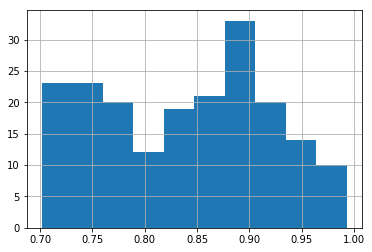

In [49]:
a['useful'].hist()

In [45]:
a['useful'].quantile(0.95)


0.6479658909399986

In [32]:
available_premises_for_conj(conjs[0]).to_frame()

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


,premises
0,dt_k5_xboole_0
1,dt_k4_xboole_0
2,idempotence_k2_xboole_0
3,d3_xboole_0
4,commutativity_k5_xboole_0
5,d5_xboole_0
6,d6_xboole_0
7,antisymmetry_r2_hidden
8,commutativity_k2_xboole_0
9,dt_k2_xboole_0


In [57]:
available_premises_for_conj('t57_tmap_1').tail()

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


4561          fc6_yellow19
4562    dt_o_2_13_yellow19
4563          t38_yellow19
4564          t34_waybel_0
4565            t5_funct_2
dtype: object

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd

In [11]:
df = pd.DataFrame([[1,2], [1,3],[3,5], [2,4]])
df.head()

,0,1
0,1,2
1,1,3
2,3,5
3,2,4


In [26]:
split = train_test_split(df[0].unique(), shuffle=True)

In [27]:
df[df[0].isin(split[0])]

,0,1
2,3,5
3,2,4


In [28]:
df

,0,1
0,1,2
1,1,3
2,3,5
3,2,4


In [77]:
df_train.shape

(82299, 9745)